# Import packages

In [2]:
import cdsapi
import os
import zipfile
import xarray as xr
import glob
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
from shapely.geometry import Polygon
import geopandas as gpd
import requests
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Functions

In [3]:
def open_and_append_netcdf(zip_file_path, concatenated_data=None):
    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('temp_folder')

    # List all files in the extracted folder
    extracted_files = os.listdir('temp_folder')

    # Filter out NetCDF files
    nc_files = [f for f in extracted_files if f.endswith('.nc')]

    # Sort NetCDF files alphabetically (optional)
    nc_files.sort()

    # Read NetCDF files using xarray and append to existing data (if any)
    for nc_file in nc_files:
        ds = xr.open_dataset(os.path.join('temp_folder', nc_file))
        if concatenated_data is None:
            concatenated_data = ds
        else:
            concatenated_data = xr.concat([concatenated_data, ds], dim='time')

    # Remove temporary extracted files
    for file in extracted_files:
        os.remove(os.path.join('temp_folder', file))
    os.rmdir('temp_folder')

    return concatenated_data

# Define AOI

Text(325.7813622872059, 0.5, 'Latitude (degrees)')

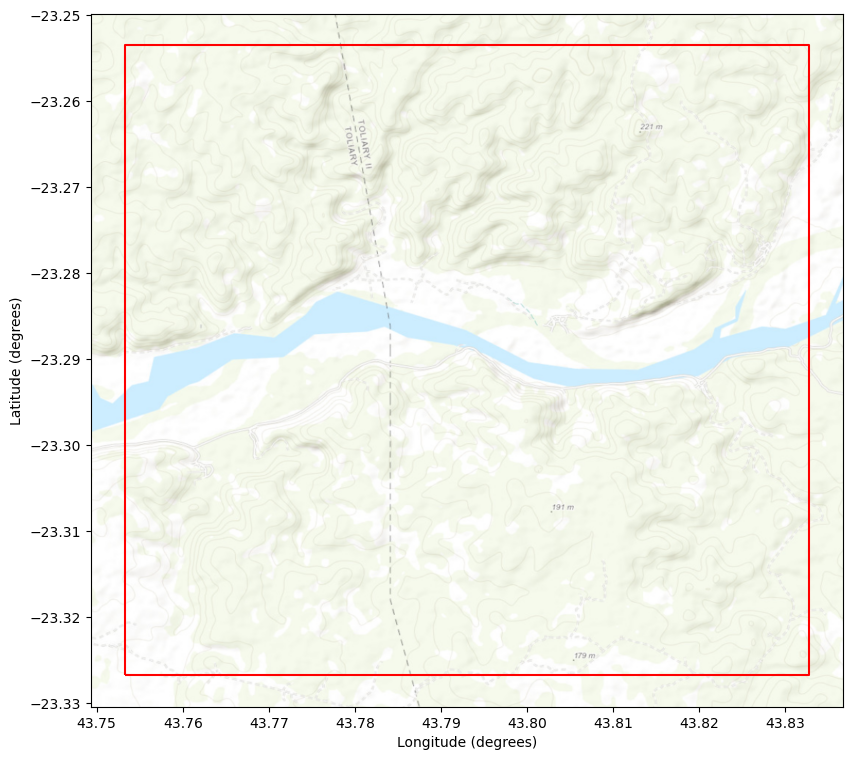

In [21]:
# Define the polygon coordinates (https://boundingbox.klokantech.com/)
polygon_coords = [[[43.7532817484,-23.3267253792],[43.8327984526,-23.3267253792],[43.8327984526,-23.2534845301],[43.7532817484,-23.2534845301],[43.7532817484,-23.3267253792]]]

# Create a shapely Polygon object
polygon = Polygon(polygon_coords[0])

# Create a GeoDataFrame with a single row containing the polygon
geometry = [polygon]
gdf_aoi = gpd.GeoDataFrame(geometry, columns=['geometry'])
bb_aoi_bounds = gdf_aoi.bounds

# Plot the grid

fig, ax = plt.subplots(figsize=(15,9))
gdf_aoi.boundary.plot(ax=ax, color='red')
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

# Define period to download

In [22]:
# Create GLOFAS directory to store downloaded files

glofas_dir = '/Users/aprida/Desktop/glofas' # Subfolder to store files per year
os.makedirs(glofas_dir, exist_ok=True)

In [30]:
# Define years, months and days to download GLOFAS discharge

year_start = 2013
year_end = 2013
month_start = 2
month_end = 3
day_start = 1
day_end = 31

years = [str(element) for element in list(range(year_start, year_end+1))]
months = [str(element) for element in list(range(month_start, month_end+1))]
days = [str(element) for element in list(range(day_start, day_end+1))]

# Download data via CDS API

In [31]:
# Define the file path
file_path = '/Users/aprida/.cdsapirc'

# Define the new URL value
new_url = 'https://ewds.climate.copernicus.eu/api'

# Open the file and edit the 'url:' line
with open(file_path, 'r') as file:
    lines = file.readlines()  # Read all lines

# Update the line that starts with 'url:'
updated_lines = [
    f'url: {new_url}\n' if line.startswith('url:') else line
    for line in lines
]

# Write the updated lines back to the file
with open(file_path, 'w') as file:
    file.writelines(updated_lines)


In [32]:
dataset = "cems-glofas-historical"

for year in years:
    
    request = {
        "system_version": ["version_4_0"],
        "hydrological_model": ["lisflood"],
        "product_type": ["consolidated"],
        "variable": ["river_discharge_in_the_last_24_hours"],
        "hyear": years,
        "hmonth": months,
        "hday": days,
        "data_format": "netcdf",
        "download_format": "zip",
        "area": [bb_aoi_bounds['maxy'][0], bb_aoi_bounds['minx'][0], bb_aoi_bounds['miny'][0],bb_aoi_bounds['maxx'][0]
                ]
    }
    
    client = cdsapi.Client()
    fn = f'{glofas_dir}/glofas_{year}.zip'
    client.retrieve(dataset, request, target=fn)

2024-12-15 17:05:15,147 INFO [2024-09-26T00:00:00] Welcome to the New [CEMS](https://emergency.copernicus.eu/) [Early Warning Data Store (EWDS)](https://ewds-beta.climate.copernicus.eu/)! This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your [feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new EWDS for the benefit of everyone. Thank you.
2024-12-15 17:05:15,153 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-15 17:05:16,136 INFO [2024-02-01T00:00:00] Please note that accessing this dataset via CDS for time-critical operation is not advised or supported
2024-12-15 17:05:16,138 INFO [2024-02-01T00:00:00] Please note we suggest checking the list of known issues on the GloFAS wiki
[here](https://confluence.ecmwf.int/display/CEMS/GloFAS+-+Known

6f2e095733a8f8a28ff64e82f8703ec2.zip:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

In [33]:
# Concatenate files per year into a single file

# List of zip files
zip_files = sorted(glob.glob(f'{glofas_dir}/*.zip'))  # Update with your zip file names

concatenated_data = None
# Process zip files
for zip_file in zip_files:
    print(f"Processing {zip_file}...")
    concatenated_data = open_and_append_netcdf(zip_file, concatenated_data)
    print(f"Data appended from {zip_file}")

# Save the concatenated data to a new NetCDF file
concatenated_data.to_netcdf(os.path.join(glofas_dir, f'glofas_dailydischarge_{years[0]}-{years[-1]}.nc'))
print("Concatenated data saved to file.")


Processing /Users/aprida/Desktop/glofas/glofas_2013.zip...
Data appended from /Users/aprida/Desktop/glofas/glofas_2013.zip
Concatenated data saved to file.


# Figures

Text(0.5, 1.0, 'Average Daily Discharge at Fiherenana River at Bemia (Cyclone Hakuna, Febraury 2013)')

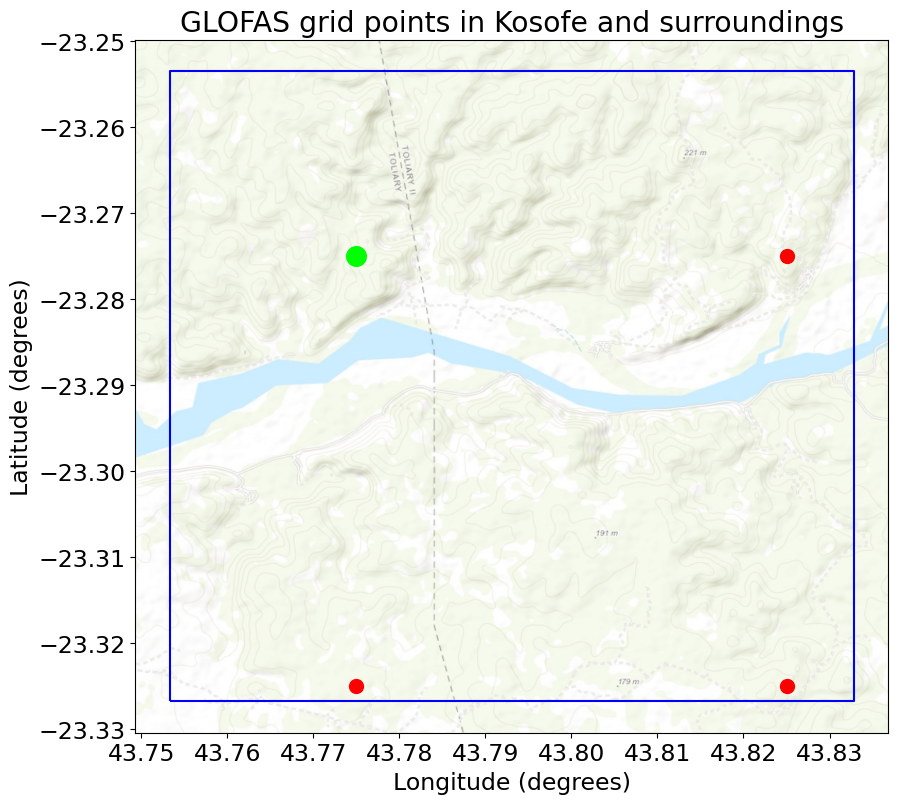

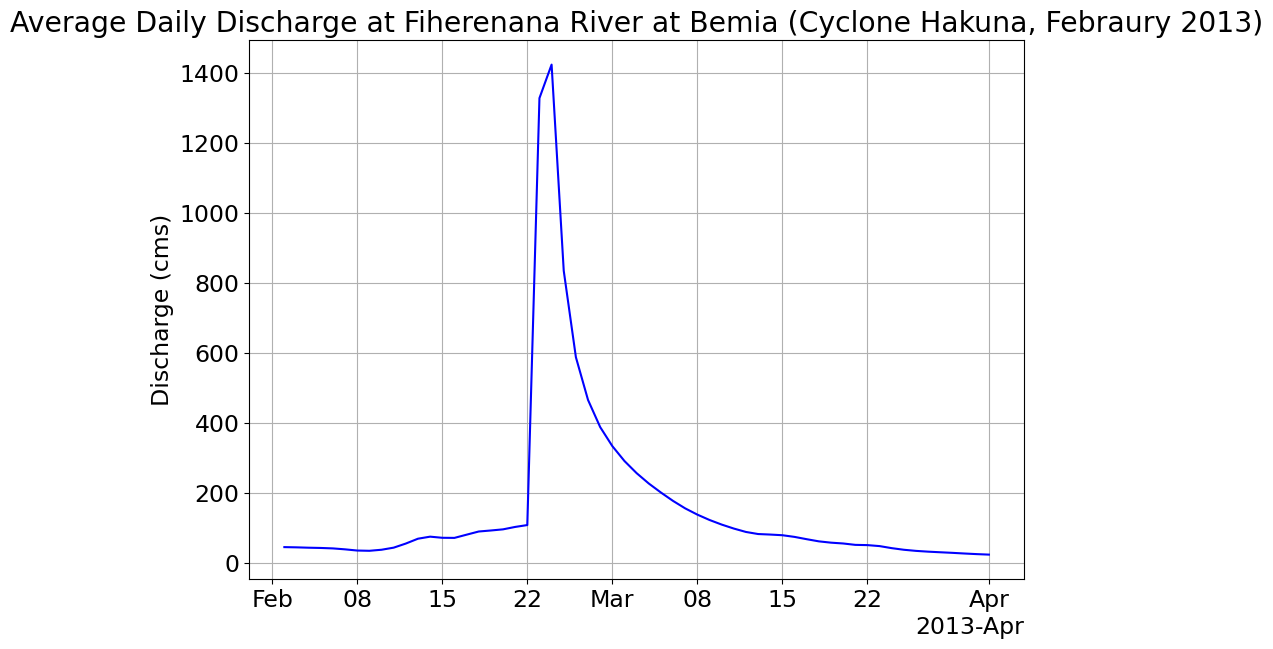

In [40]:
fn = os.path.join(glofas_dir, f'glofas_dailydischarge_{years[0]}-{years[-1]}.nc')
concatenated_data = xr.open_dataset(fn)
longitudes = concatenated_data['longitude']
latitudes = concatenated_data['latitude']

# Create meshgrid for plotting
lon_mesh, lat_mesh = xr.broadcast(longitudes, latitudes)
df_grid = lon_mesh.to_dataframe().drop(columns=['surface', 'longitude']).reset_index()
df_grid['q_max'] = 0
variable = concatenated_data['dis24']

# Iterate over all lat/lon combinations

for index, row in df_grid.iterrows():
    # Extract the time series for the current lat/lon
    series = variable.sel(latitude=row['latitude'], longitude=row['longitude'])
    df_grid.loc[index, 'q_max'] = series.values.max()

lon_sel = df_grid[df_grid['q_max'] == df_grid['q_max'].max()].longitude
lat_sel = df_grid[df_grid['q_max'] == df_grid['q_max'].max()].latitude

# Plot the grid
plt.rcParams['font.size'] = 17
fig, ax = plt.subplots(figsize=(15,9))
plt.plot(lon_mesh, lat_mesh, 'r.', markersize=20)
gdf_aoi.boundary.plot(ax=ax, color='blue')
plt.scatter(lon_sel, lat_sel, color='lime', zorder=2, s=200)
cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap, attribution=False)
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')
ax.set_title('GLOFAS grid points in Kosofe and surroundings')

# Plot discharge time-series at maximum point

q_sel = concatenated_data['dis24'].sel(longitude=lon_sel.values, latitude=lat_sel.values)

fig, ax = plt.subplots(figsize=(10,7))
q_sel.plot(ax=ax, color='blue')
ax.set_xlabel('')
ax.set_ylabel('Discharge (cms)')
ax.grid()
ax.set_title(f'Average Daily Discharge at Fiherenana River at Bemia (Cyclone Hakuna, Febraury 2013)')